# Convolutional AutoEncoders

Autoencoders are a type of neural network where the input is also the output. They are an unsupervised learning algorithm, meaning that they do not require labeled data. An autoencoder consists of two parts: an encoder and a decoder. They follow the same principle of dimensionality reduction as in linear algebra, but using a neural network. The idea is to take a higher-dimensional input, project it into a lower-dimensional space, and then project it back into the input space. Figure 1 shows the typical architecture of autoencoders.

The encoder receives the input and encodes it into a lower dimension. This encoding is simply called the code. The code represents the summary of the input. The decoder takes this code and reconstructs the input from it.

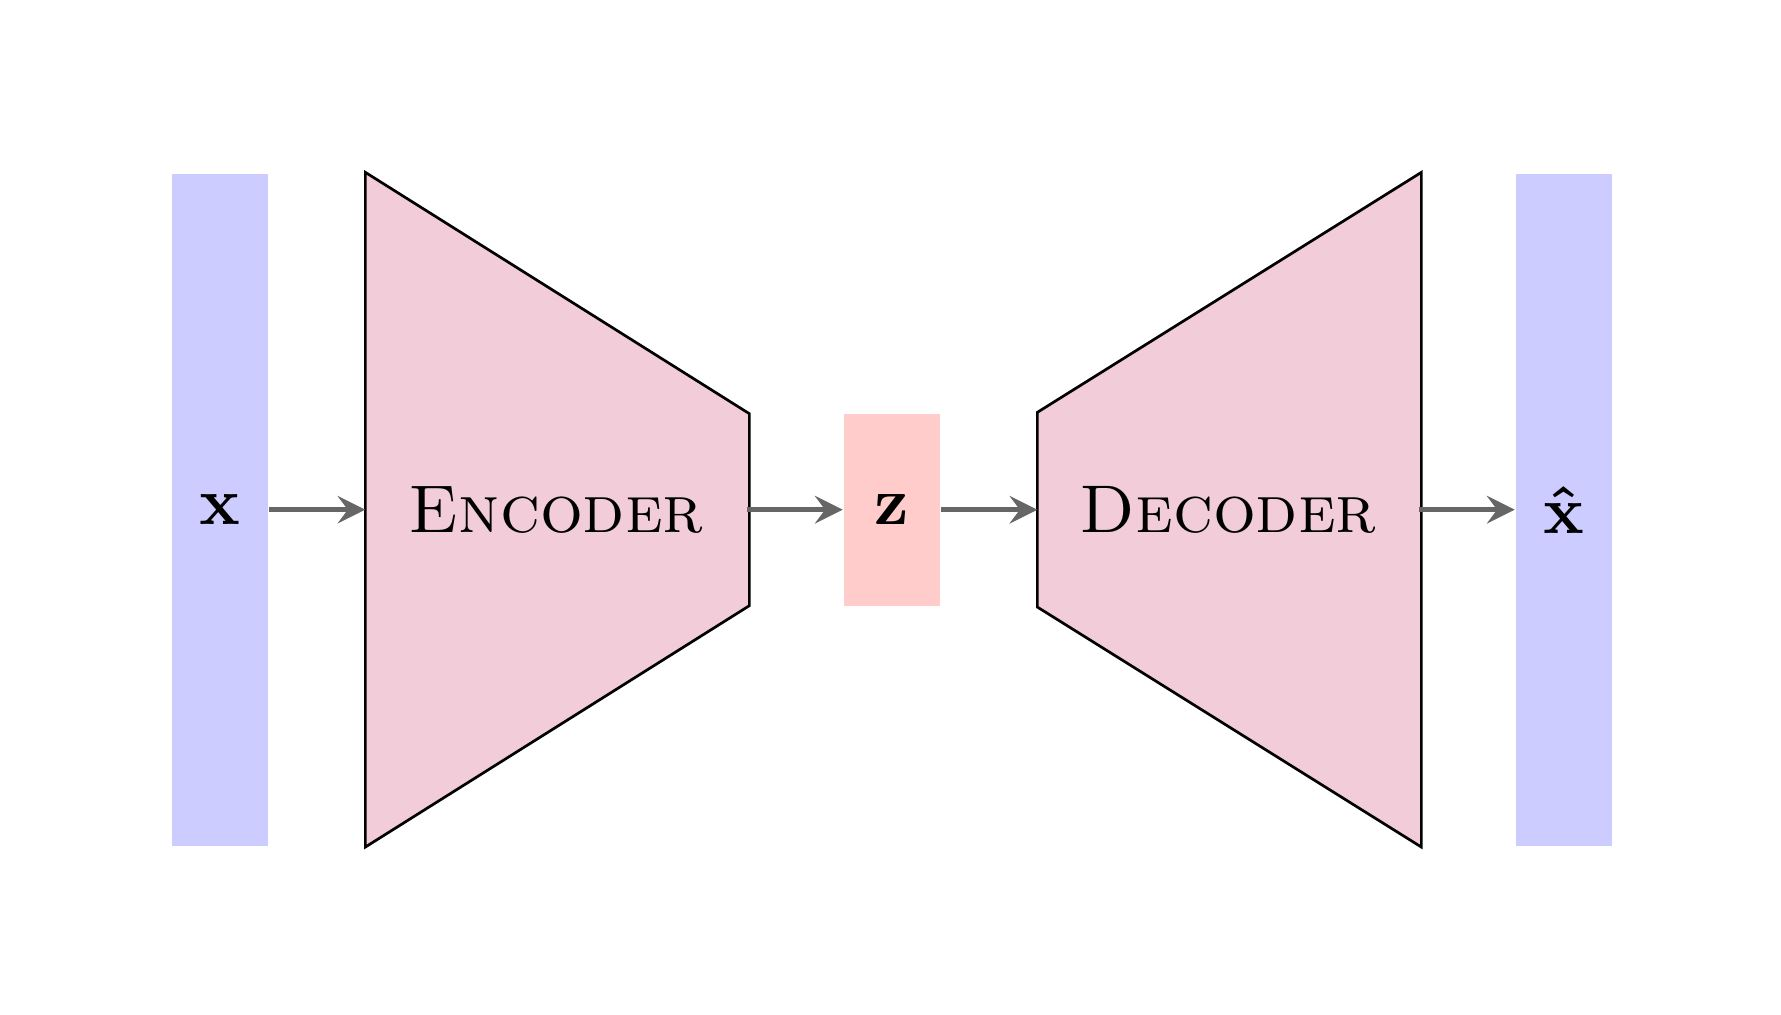
<p align = "center">
Fig.1 - Autoencoder Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

We will try to visualize the generative power of autoencoders in this tutorial by generating new samples based on input images. Some other use cases of autoencoders include the following:
 - Image Denoising (the input is noisy image and output is denoised image)
 - Image completion (the input is an image with a patch missing and the output is completed image)
 - Data encoding and dimenensionality reduction.

In [1]:
# Load fossil data
from google.colab import files
src = list(files.upload().values())[0]
open('dataloader_fossilnet.py','wb').write(src)

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from dataloader_fossilnet import FossilNET

In [5]:
#Model-Hyperparameters
EPOCHS = 100
LEARNING_RATE = 5e-4
BATCH_SIZE = 64
Z = 256

In [6]:
# We will be using the Fossil dataset

transform = transforms.Compose([
        transforms.Resize(75),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform, download=True)
print(f'Training samples {len(training_data)}')

# Randomly select a small subset of samples
# training_data = torch.utils.data.Subset(training_data, np.random.choice(len(training_data), 600, replace=False))

Downloading...


Downloading...
From (original): https://drive.google.com/uc?id=1_2TK0hC_b3mliXajPcobV-eq-3HNXd3q
From (redirected): https://drive.google.com/uc?id=1_2TK0hC_b3mliXajPcobV-eq-3HNXd3q&confirm=t&uuid=a381ddfe-a854-467c-86f3-cfa0b82c9414
To: c:\Osamah\Programming\Projects\Python 3\KAUST_AI_Summer_2024\Week 3 - Generative Deep Learning\02- AudoEncoders\ae\dataset\FossilNET.zip
100%|██████████| 193M/193M [00:18<00:00, 10.2MB/s] 


Done!
Training samples 2000


In [7]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

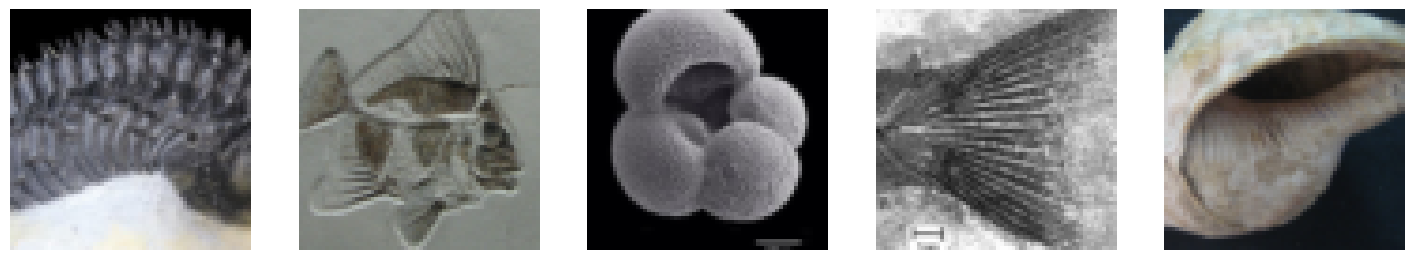

In [8]:
# Visualizing some sample images
figure = plt.figure(figsize=(18, 14))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), interpolation='none')
plt.show()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We will now build the autoencoder model as shown in Figure 2. It is common practice to build the encoder and decoder as inverses of each other, but this is not strictly necessary as long as the input and output spaces are the same.

The representational power of the encoder depends on the size of the encoder network and the encoding dimension. The larger the encoder network and the value of z (encoding dimension), the better the representation, but this can come at the cost of overfitting. Therefore, it is important to balance these two factors.

Typically, there is no activation function on the encoding layer. However, in this case, since our goal is to sample the encodings and generate new samples, it is better to limit the space of encodings. Therefore, we will apply a tanh activation function at the encoding layer to limit the encoding space.

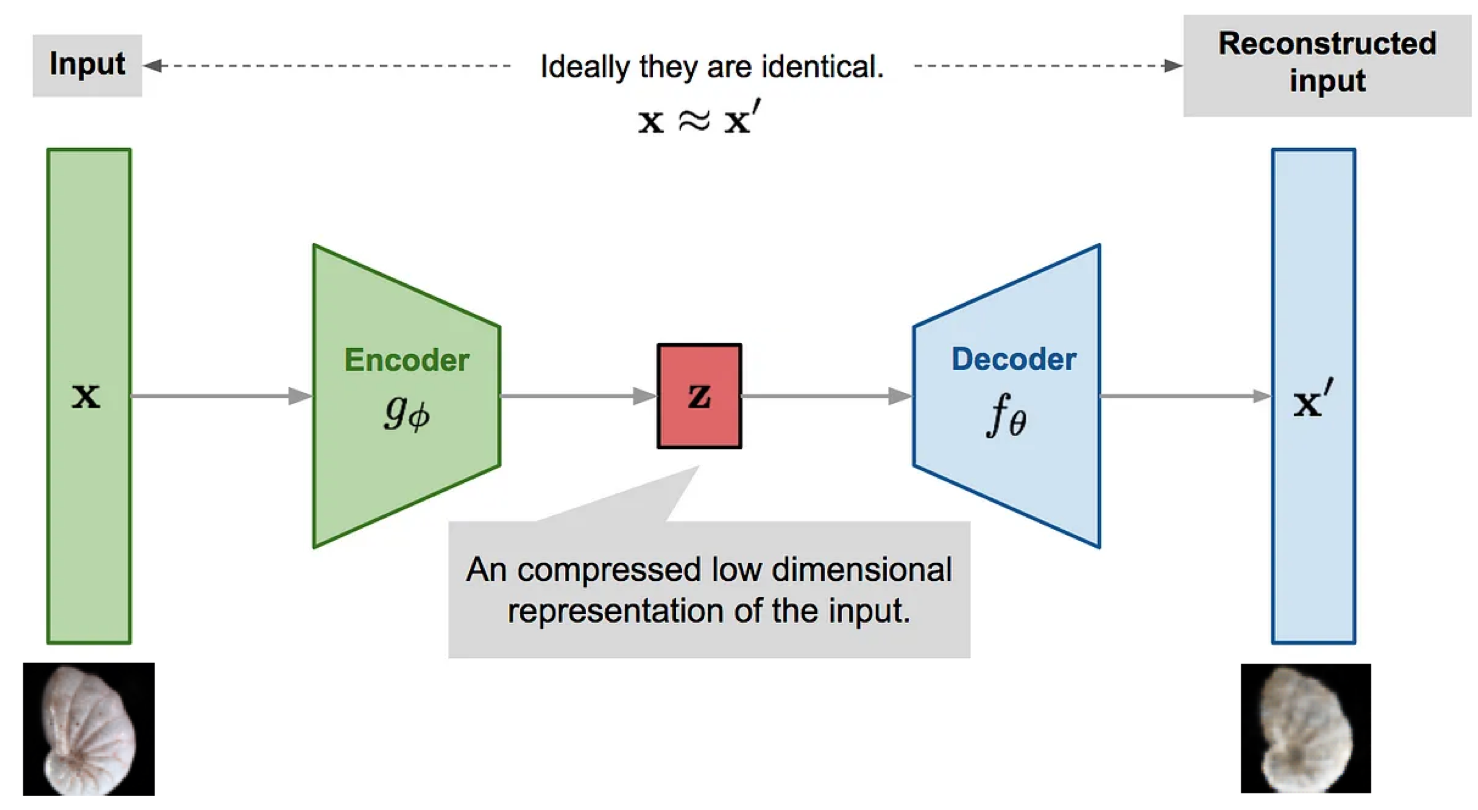
<p align = "center">
Fig.2 - Sample image of an Autoencoder  
(<a href="https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e">
source
</a>)
</p>

In [10]:
class Reshape(nn.Module):
    """A custom reshape layer."""
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class AutoEncoder(nn.Module):
    """Autoencoder model"""
    def __init__(self, z, nwh):
        super(AutoEncoder, self).__init__()
        self.z = z
        self.nwhlat = nwh // 8
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Flatten(1,-1),
            nn.Linear(128 * self.nwhlat * self.nwhlat, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, z),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, 128 * self.nwhlat * self.nwhlat),
            nn.BatchNorm1d(128 * self.nwhlat * self.nwhlat),
            nn.LeakyReLU(),

            Reshape((-1,128,self.nwhlat,self.nwhlat)),

            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = AutoEncoder(z=Z, nwh=64)
model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): Tanh()
  )
  (decoder): Sequential(
  

In [11]:
# model summary
summary(model, (3,64,64))

#Number of parameters calculation
#https://medium.com/@iamvarman/how-to-calculate-the-number-of-parameters-in-the-cnn-5bd55364d7ca
#Convolutional_1 : ((kernel_size)*stride+1)*filters) = 3*3*1+1*32 = 320 parameters. In first layer, the convolutional layer has 32 filters.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         LeakyReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          36,992
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         LeakyReLU-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 512]       4,194,816
      BatchNorm1d-12                  [-1, 512]           1,024
        LeakyReLU-13                  [-1, 512]               0
           Linear-14                  [

Typically, mean squared is used as the loss function for autoencoders. The  objective is to minimize the following:
$$ L(x,\hat{x}) = \frac{1}{N} \sum^{N}_{i=1} ||x_{i}-\hat{x}_{i}||^{2} $$

In [12]:
# Defining the optimizer and loss function here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

In [13]:
# Training loop
loss_history = []
for i in range(1,EPOCHS+1):
    running_loss = 0
    pbar = tqdm(train_dataloader)
    for b, data in enumerate(pbar):
        # Every data instance is an input + label pair. We don't need the label
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update Progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})
    loss_history.append(running_loss)

Epoch 100/100: : 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.00648, avloss=0.00486]


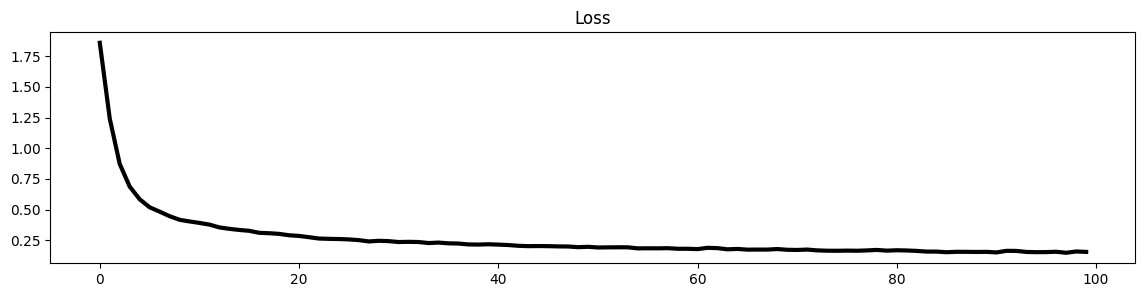

In [14]:
# Visualizing the loss function
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss');

In [15]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [16]:
# Set the model to eval state
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): Tanh()
  )
  (decoder): Sequential(
  

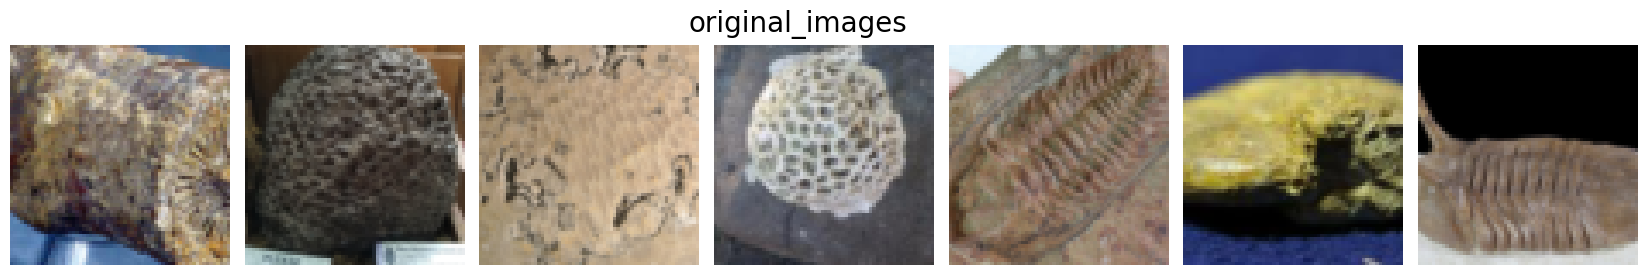

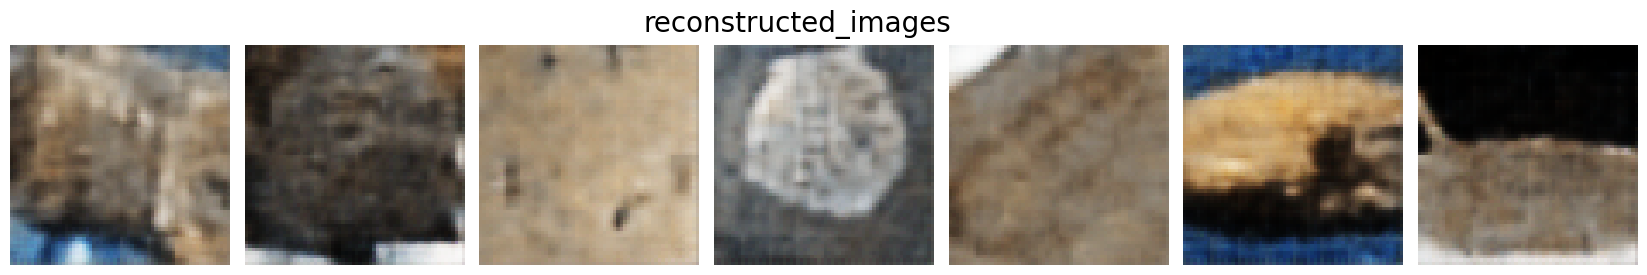

In [17]:
# Display some sample images and there reconstruction through auto encoders

images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")
with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device)).cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")


### Generation through Auto Encoders

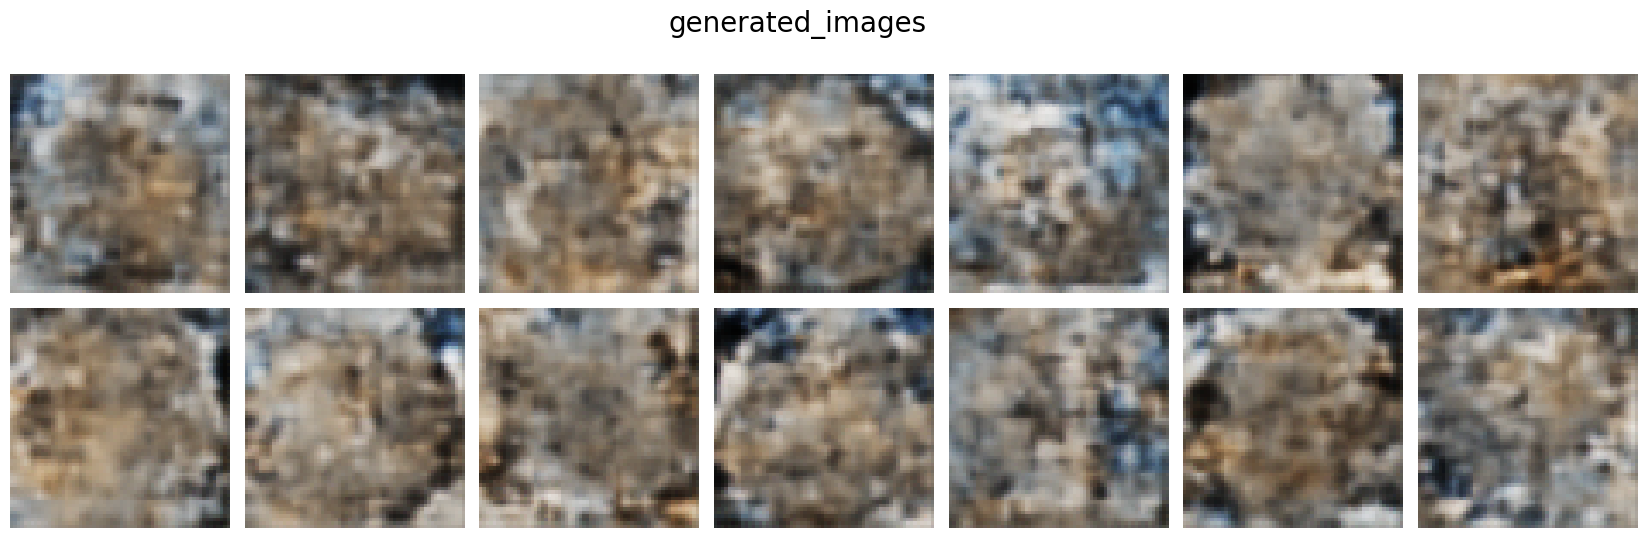

In [18]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder
rows, cols = 2, 7
sample_encodings = (torch.rand(rows*cols, Z).to(device) - 0.5) * 2 # encoding space: [-1,1)
with torch.no_grad():
    generations = model.decoder(sample_encodings).cpu()
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

### Discussion

As we can see, we achieved near perfect image reconstruction for the data with a very small value of Z(=32). One of the reason is obviously because the input data itself of low dimenstion but the other is that autoencoders are fairly good at encoding the data.

But in the case of generation, we did not get good results. This goes to show us that auto encoders have very low generative abilities because they tend to overfit and just learn the function that maps the input to output.

# Extra Exercise: Try another dataset, such as

*   MNIST
*   Fashion-MNIST



